In [1]:
import uproot as upr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yaml
from ROOT import vector, RDataFrame, RDF, TFile, TH1F, TH2F, gInterpreter, TMath
from src.general.utils import toVector, get_files, prep_filelist
from time import perf_counter

Welcome to JupyROOT 6.22/09


In [2]:
#GenPart_pdgId, GenPart_pt, and GenPart_statusFlags bit 7 or 8

In [3]:
#set up metadata for files
era = '2016'
deepflavour = False
deepcsv = True
extras = False
csv_v_flavor=False
if era == "2016":
    fname = "samplesCR_2016_Apr2020.yml"
    bDiscValue = 0.3093
if era == "2017":
    fname = "samplesCR_2017_Apr2020.yml"
    bDiscValue = 0.3033
if era == "2018":
    fname = "samplesCR_2018_Apr2020.yml"
    bDiscValue = 0.2770


sampleDir = "samples"
outname = fname.replace('.yml','.root')
fname = "{}/{}".format(sampleDir, fname)
outname, fname

('samplesCR_2016_Apr2020.root', 'samples/samplesCR_2016_Apr2020.yml')

In [4]:
sample_path ='/eos/cms/store/group/phys_exotica/bffZprime/nanoAODskimmed/crab_bffv2/{}/{{}}'.format(era)
eff_path ='/eos/cms/store/group/phys_exotica/bffZprime/nanoAODskimmed/crab_bff_eff/{}/{{}}'.format(era)

class sample_processor():
    '''Class that takes file name from yml and helps manage samples.'''
    def __init__(self,file_name,outname,bDiscValue,is_inclusive=0):
        #load config
        self.file_name = file_name
        with open(file_name,'r') as f:
            self.sample_dict = yaml.load(f, Loader=yaml.FullLoader)
        #setup outfile
        self.outname = outname
        self.out = TFile(outname, 'recreate')
        self.outdirs_dict = {}
        for sample in self.samples():
            name = sample['name']
            self.outdirs_dict[name] = self.out.mkdir(name)
        self.lumi = self.sample_dict['lumi']
        #get and write lumi info
        hlumi = TH1F("lumi", "lumi", 1, 0, 1)
        hlumi.SetDirectory(self.out)
        hlumi.SetBinContent(1, self.lumi)
        hlumi.Write()
        self.bDiscValue = bDiscValue
        self.is_inclusive = is_inclusive
    def samples(self):
        return self.sample_dict['samples']
    def sample_names(self):
        return [s['name'] for s in self.samples()]
    def close(self):
        self.out.Close()
    def __repr__(self):
        text_dict = {"fn":self.file_name,
                     "on":self.outname, 
                     "lumi":self.lumi,
                    "samples": self.sample_names()}
        return '''from {fn} to {on}\nlumi: {lumi}\nSamples {samples}'''.format(**text_dict)

In [5]:
sp = sample_processor(fname, outname, bDiscValue)

In [6]:
def check_bitwise(value, n):
    return value & (1 << n)== 1 << n
def hard_process(value):
    return check_bitwise(value, 7) or check_bitwise(value, 8)

def b_jet(value):
    return abs(value)==5

def s_jet(value):
    return abs(value)==3

def return_jet_multiplicty(nevents):
    event = df.loc[nevents]
    print(event)
    ishardprocess = event.GenPart_statusFlags.apply(hard_process)
    isbjet = event.GenPart_pdgId.apply(b_jet) & ishardprocess
    issjet = event.GenPart_pdgId.apply(s_jet) & ishardprocess
    print(isbjet)
    print(issjet)

    nbjet = isbjet.sum()
    nsjet = issjet.sum()
    return {"GenNbJets": nbjet, "GenNsJets": nsjet, "nGenPart": len(event)}

In [7]:
def make_dataframe():

    njets = []
    start = perf_counter()
    nevents = len(events)
    nevents = 10
    for i in range(nevents):
        current = perf_counter()
        if i % 100==0: 
            print(i, i/nevents)
            if i > 0:
                td = current-start
                nsteps = i/int(100)
                tps = td/nsteps
                steps_remaining = nevents/100 - nsteps
                time_remaining =  tps*steps_remaining
                print(current-start, nsteps, time_remaining)

        njets.append(return_jet_multiplicty(i))
    jet_df = pd.DataFrame(njets)
    return jet_df

In [8]:
for sample in sp.samples():
    name = sample['name']
    if not 'BFF' in name: continue
    if not '175' in name: continue
    if not '0p5' in name: continue
    files_df = get_files(sample['fileglob'], sample_path)
    file = files_df.file.iloc[0]
    events = upr.open(file)['Events']
    df = events.arrays(['GenPart_pdgId', 'GenPart_pt', 'GenPart_statusFlags'], library='pd')
    jet_df = make_dataframe()

0 0.0
          GenPart_pdgId  GenPart_pt  GenPart_statusFlags
subentry                                                
0                    -5    0.000000                10625
1                     3    0.000000                14721
2                    32    0.000000                 4481
3                    32   80.250000                10497
4                   -13   54.625000                 4481
5                    13  134.000000                22913
6                    13  134.000000                  257
7                    22    0.006104                12289
8                   -13   54.625000                18689
9                   -13   54.625000                 8449
10                   22    0.000106                12289
11                   13  134.000000                 8449
12                   -3   23.000000                    1
13                    3    7.671875                 8193
14                   -3    3.523438                 8193
15                 -513  

          GenPart_pdgId  GenPart_pt  GenPart_statusFlags
subentry                                                
0                     5    0.000000                10625
1                    -5    0.000000                10625
2                    32    0.000000                 4481
3                    32   27.875000                10497
4                   -13   77.500000                12673
5                    13   54.375000                12673
6                   511   12.031250                12291
7                  -521    5.312500                12291
8                   411    1.960938                12291
9                     1    2.265625                 8193
10                   -4    3.585938                 8193
11                 -413    2.789062                12291
12                   14    4.843750                12352
13                  -13    0.374023                12352
14                  421    1.945312                12354
15                 -421    2.58

In [12]:
hard_process(8193)

False

In [10]:
jet_df

,GenNbJets,GenNsJets,nGenPart
0,1,1,31
1,2,0,29
2,1,1,13
3,1,1,22
4,1,1,45
5,2,1,26
6,2,0,19
7,2,0,23
8,1,1,16
9,2,0,19


In [ ]:
hist = np.histogram(jet_df.GenNbJets, bins=np.linspace(-.5,7.5, 9))

sum([   0,   93, 3295, 2767, 3563, 1540,  492,  120]), hist[0]*int(len(events)/nevents)

In [ ]:
11870/250000

Text(0.5, 1.0, 'before selection')

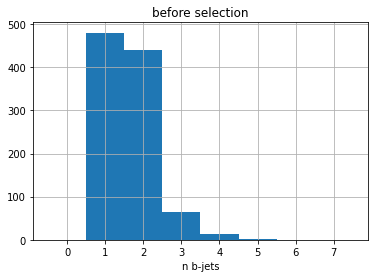

In [59]:
jet_df.GenNbJets.hist(bins=np.linspace(-.5,7.5, 9))
plt.xlabel('n b-jets')
plt.title('before selection')

Text(0.5, 1.0, 'before selection')

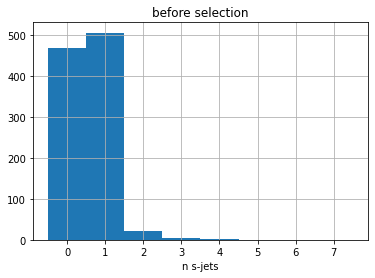

In [60]:
jet_df.GenNsJets.hist(bins=np.linspace(-.5,7.5, 9))
plt.xlabel('n s-jets')
plt.title('before selection')

In [135]:
hist = np.histogram(jet_df.GenNsJets, bins=np.linspace(-.5,7.5, 9))
hist[0]*25

array([121925, 121675,   5675,    600,    125,      0,      0,      0])

In [21]:
df.size

2000